<a href="https://colab.research.google.com/github/JannaBabicheva/lab02_deep_learning/blob/main/lab02_part3_poetry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs.

You have several choices here:

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os

### Data loading: "Евгений Онегин"


In [2]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = [x.replace('\t\t', '') for x in text]

--2024-12-14 20:55:19--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt.3’

onegin.txt.3        100%[===================>] 256.37K  --.-KB/s    in 0.04s   

2024-12-14 20:55:20 (6.95 MB/s) - ‘onegin.txt.3’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
# Объединяем все строки в одну и приводим к нижнему регистру
text = ''.join(text).lower()

Put all the characters, that you've seen in the text, into variable `tokens`.

In [4]:
# Создаем набор уникальных символов
tokens = sorted(set(text))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [5]:
# Создаем словари для преобразования символов в индексы и обратно
# dict <index>:<char>
idx_to_token = {idx: char for idx, char in enumerate(tokens)}
# dict <char>:<index>
token_to_idx = {char: idx for idx, char in enumerate(tokens)}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

Построение RNN модели

In [6]:
# Your code here

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [8]:
# Параметры модели
input_size = len(tokens)
hidden_size = 256
output_size = len(tokens)
seq_length = 100
batch_size = 32
learning_rate = 0.001
num_epochs = 100

In [14]:
# Функция генерации текста
def generate_sample(model, seed_phrase='Онегин', max_length=500, temperature=1.0):
    model.eval()  # переключаем модель в режим оценки
    with torch.no_grad():  # отключаем вычисление градиентов
        # Инициализация
        current_sequence = seed_phrase
        hidden = model.initial_state()

        # Генерация текста
        for _ in range(max_length - len(seed_phrase)):
            # Получаем последний символ
            input_tensor = torch.zeros(1, input_size)
            input_tensor[0][token_to_idx[current_sequence[-1]]] = 1

            # Получаем предсказание модели
            output, hidden = model(input_tensor, hidden)

            # Применяем температуру к выходным значениям
            output_dist = (output.squeeze() / temperature).exp()

            # Выбираем следующий символ
            top_char_idx = torch.multinomial(output_dist, 1)[0]
            predicted_char = idx_to_token[top_char_idx.item()]

            # Добавляем символ к последовательности
            current_sequence += predicted_char

        return current_sequence


In [10]:
# Определение модели
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=0.2):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_tensor, hidden_tensor):
        input_tensor = self.dropout(input_tensor)
        combined = torch.cat((input_tensor, hidden_tensor), 1)
        hidden = self.dropout(torch.tanh(self.i2h(combined)))
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initial_state(self, batch_size=1):
        return torch.zeros(batch_size, self.hidden_size)



In [11]:
# Обучение модели
model = RNN(input_size, hidden_size, output_size)
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
# Функция для получения тренировочных данных
def get_batch():
    idx = np.random.randint(0, len(text) - seq_length - 1)
    input_seq = text[idx:idx + seq_length]
    target_seq = text[idx + 1:idx + seq_length + 1]

    input_tensor = torch.zeros(seq_length, input_size)
    for i, char in enumerate(input_seq):
        input_tensor[i][token_to_idx[char]] = 1

    target_tensor = torch.tensor([token_to_idx[char] for char in target_seq])
    return input_tensor, target_tensor

In [15]:
losses = []
print("Training started...")

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in range(batch_size):
        # Получаем batch данных
        input_tensor, target_tensor = get_batch()

        # Инициализируем скрытое состояние для каждого батча
        hidden = model.initial_state()

        # Обнуляем градиенты
        optimizer.zero_grad()

        batch_loss = 0
        outputs = []

        # Проходим по последовательности
        for i in range(seq_length):
            output, hidden = model(input_tensor[i].unsqueeze(0), hidden.detach())  # Добавили .detach()
            batch_loss += criterion(output, target_tensor[i].unsqueeze(0))

        # Усредняем loss
        batch_loss = batch_loss / seq_length

        # Обратное распространение
        batch_loss.backward()

        # Ограничение градиентов
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

        # Шаг оптимизатора
        optimizer.step()

        total_loss += batch_loss.item()

    # Сохраняем среднее значение функции потерь
    avg_loss = total_loss / batch_size
    losses.append(avg_loss)

    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {avg_loss:.4f}')

        # Генерируем пример текста каждые 10 эпох
        if epoch > 0:
            print("\nПример генерации:")
            print(generate_sample(model, temperature=0.7)[:100])
            print()

print("Training completed!")

Training started...
Epoch [0/100], Loss: 3.2297
Epoch [10/100], Loss: 3.0348

Пример генерации:
Онегинз аят гиеу уос
рисн улyм,уиб еещие пое;а ое орылеlвлонай
ссернеетак кеоуд м неер
иет ары аногш

Epoch [20/100], Loss: 2.9564

Пример генерации:
Онегинтолоевнрме  cе  ди вареяоне к
 о ы ни ктз

мле ло ноко пет,и, нст сид?е репе зо твблыан с еет


Epoch [30/100], Loss: 2.8723

Пример генерации:
Онегинеыри
авза нее цвот  нтодах р
е
.
и 
стрыне не ррит
дны вжло  намы тту учеа едстапер,мын,енп -а

Epoch [40/100], Loss: 2.8569

Пример генерации:
Онегинат н
т овгнаа тупоно е ная ве
ели о
тумлско с шибмянемоне трт ревоена
  о то та ь тег, суенее 

Epoch [50/100], Loss: 2.8097

Пример генерации:
Онегинеляни м
е те снаем чанена скотого  ваеужаль вемиtслу че
е поесвя  нерислав фоснав иде дади мро

Epoch [60/100], Loss: 2.7381

Пример генерации:
Онегини ероглт дов мынн …
хxи брей резогта заталерта сведонс м петелно при  о резь. мнчаельсаени ней

Epoch [70/100], Loss: 2.7545

Пример генерации:
Онег

In [16]:
# После обучения можно генерировать текст с разными температурами
print("\nГенерация текста с разными температурами:\n")
temperatures = [0.2, 0.5, 1.0, 2.0]

for temp in temperatures:
    print(f"\nТемпература: {temp}")
    generated_text = generate_sample(model, temperature=temp)
    print(generated_text)
    print("-" * 50)


Генерация текста с разными температурами:


Температура: 0.2
Онегины порене та то на ста на о о пореда ста и и ста на но о пород воль на но во на воста пораза и столи  во ной породо но на нов серени се серев дем не се вето вот тото прет по воров тально сто на стельной валоной не ста пород и водет посто на поредеть на да се сто поред не во восто не  сле не на дорен не пол на не порани преда породеть на вет серадене и сто пол о сто не сересто на порни делени сто и сти на мона сто на не вери сто на но но о оло да ста на на сто не да на ста сто но ве перадо н
--------------------------------------------------

Температура: 0.5
Онегиней, у си тони о те васобельо но вонно дало на сеной саслорой с о на сака  естой вод вато кизарой дт почьемне бе то встом зит я нений вотеена рал
но т м иний ве та стально дыло лах полано ла на огом на свери томното  сеной ми не сороднте по мо орена с ие лов та и ередну пористототной ста ве мудний о же в и нась ммее волес да ну вое дамнем
потвне м се зей нестор

Plot the loss function (axis X: number of epochs, axis Y: loss function).

Код для графика функции потерь

In [ ]:
# Your plot code here

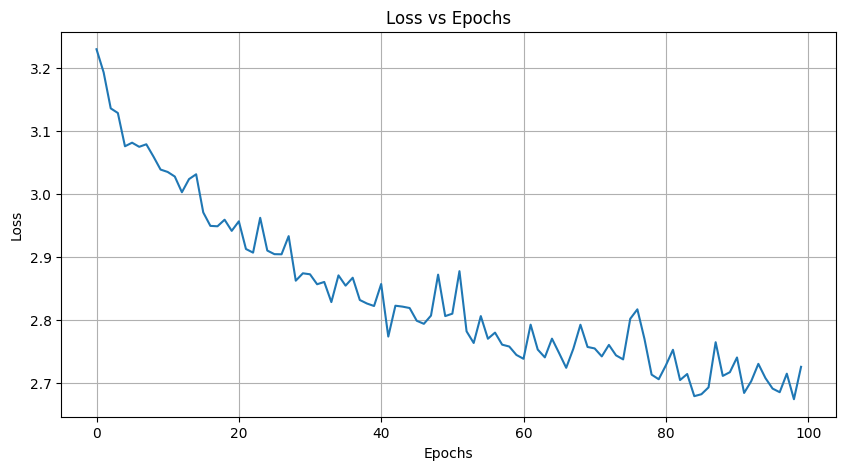

In [17]:
# Построение графика функции потерь
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [13]:
# def generate_sample(char_rnn, seed_phrase=' Hello', max_length=MAX_LENGTH, temperature=1.0):
#     '''
#     ### Disclaimer: this is an example function for text generation.
#     ### You can either adapt it in your code or create your own function

#     The function generates text given a phrase of length at least SEQ_LENGTH.
#     :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
#     :param max_length: maximum output length, including seed_phrase
#     :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
#         smaller temperature converges to the single most likely output.

#     Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
#     of the next symbol.
#     '''

#     x_sequence = [token_to_id[token] for token in seed_phrase]
#     x_sequence = torch.tensor([[x_sequence]], dtype=torch.int64)
#     hid_state = char_rnn.initial_state(batch_size=1)

#     #feed the seed phrase, if any
#     for i in range(len(seed_phrase) - 1):
#         print(x_sequence[:, -1].shape, hid_state.shape)
#         out, hid_state = char_rnn(x_sequence[:, i], hid_state)

#     #start generating
#     for _ in range(max_length - len(seed_phrase)):
#         print(x_sequence.shape, x_sequence, hid_state.shape)
#         out, hid_state = char_rnn(x_sequence[:, -1], hid_state)
#         # Be really careful here with the model output
#         p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]

#         # sample next token and push it back into x_sequence
#         print(p_next.shape, len(tokens))
#         next_ix = np.random.choice(len(tokens), p=p_next)
#         next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
#         print(x_sequence.shape, next_ix.shape)
#         x_sequence = torch.cat([x_sequence, next_ix], dim=1)

#     return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [18]:
def generate_sample(model, seed_phrase='Онегин', max_length=500, temperature=1.0):
    model.eval()  # переключаем модель в режим оценки
    with torch.no_grad():  # отключаем вычисление градиентов
        # Инициализация
        current_sequence = seed_phrase
        hidden = model.initial_state()

        # Генерация текста
        for _ in range(max_length - len(seed_phrase)):
            # Получаем последний символ
            input_tensor = torch.zeros(1, input_size)
            input_tensor[0][token_to_idx[current_sequence[-1]]] = 1

            # Получаем предсказание модели
            output, hidden = model(input_tensor, hidden)

            # Применяем температуру к выходным значениям
            output_dist = (output.squeeze() / temperature).exp()
            # Выбираем следующий символ
            top_char_idx = torch.multinomial(output_dist, 1)[0]
            predicted_char = idx_to_token[top_char_idx.item()]

            # Добавляем символ к последовательности
            current_sequence += predicted_char

        return current_sequence

# Пример использования
print("\nГенерация текста с разными температурами:\n")

temperatures = [0.2, 0.5, 1.0, 2.0]
for temp in temperatures:
    print(f"\nТемпература: {temp}")
    print(generate_sample(model, temperature=temp))
    print("-" * 50)


Генерация текста с разными температурами:


Температура: 0.2
Онегине не на оне вет о толени воралени пира сто на сто во но на и но о палине поредна сто ной сто во ороне поради в дала на но о валь на да ста олосто ной дала серода но не ной вора вол ста не не со предета на сто не трони сто  о се вель на беленне ст не  реней посто на сера се во го на серене не вам на толен се посто та но на сто не сто на провет поре поста сто не пом со пом лене сорана сто о пораста на и сто ворасто на сто на ней не но о поле не  о— за столь о воне во ородоле на ви прада но н
--------------------------------------------------

Температура: 0.5
Онегинь ни гое порола ве во вородани е на пракесте дала стереса,
и соно не продруге си стр чете сгорим и виле дотоене стре лоно не т тань настаодана са утакнн минась вний поистот во молод талнн вери та потая стат и сутредак те сае ном, поля я ной ди ра мечтом мот ле друже на пра продвенетья,
и порь;


xxxi

ор удото поракой тононадвшн воримны

о валено пом осто но ч

In [ ]:
# An example of generated text.
# print(generate_text(length=500, temperature=0.2))

hide my will in thine?
  shall will in of the simend that in my sime the seave the seave the sorll the soren the sange the seall seares and and the fart the wirl the seall the songh whing that thou hall will thoun the soond beare the with that sare the simest me the fart the wirl the songre the with thy seart so for shat so for do the dost the sing the sing the sing the soond canding the sack and the farling the wirl of sore sich and that with the seare the seall so fort the with the past the wirl the simen the wirl the sores the sare


Улучшенный вариант модели

In [19]:
class EnhancedRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=3):
        super(EnhancedRNN, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.embedding = nn.Linear(input_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, n_layers, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        embedded = self.dropout(torch.tanh(self.embedding(x)))
        output, hidden = self.rnn(embedded, hidden)
        output = self.dropout(output)
        output = self.fc(output)
        return output, hidden

    def initial_state(self, batch_size=1):
        return torch.zeros(self.n_layers, batch_size, self.hidden_size)

In [20]:
def generate_better_sample(model, seed_phrase='Онегин', max_length=200, temperature=1.0):
    model.eval()
    with torch.no_grad():
        current_sequence = seed_phrase
        hidden = model.initial_state()

        # История последних N символов для предотвращения повторов
        last_chars = []
        max_history = 10

        for _ in range(max_length - len(seed_phrase)):
            input_tensor = torch.zeros(1, 1, input_size)
            input_tensor[0, 0, token_to_idx[current_sequence[-1]]] = 1

            output, hidden = model(input_tensor, hidden)
            output = output[0, -1]

            # Применяем температуру
            output_dist = (output / temperature).softmax(dim=-1)

            # Уменьшаем вероятности часто используемых символов
            for char in last_chars:
                if char in token_to_idx:
                    output_dist[token_to_idx[char]] *= 0.7

            # Выбираем следующий символ
            next_char_idx = torch.multinomial(output_dist, 1)[0]
            next_char = idx_to_token[next_char_idx.item()]

            # Обновляем историю
            last_chars.append(next_char)
            if len(last_chars) > max_history:
                last_chars.pop(0)

            if next_char.isprintable() and next_char != '\t':
                current_sequence += next_char

            # Добавляем точку и новую строку после некоторого количества символов
            if len(current_sequence) % 50 == 0:
                current_sequence += '.\n'

        return current_sequence

In [21]:
# Создаем и обучаем улучшенную модель
model = EnhancedRNN(input_size, hidden_size, output_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [22]:
# Обучение с более длинными последовательностями
seq_length = 200
batch_size = 32
num_epochs = 300

losses = []
print("Начало обучения...")

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for _ in range(batch_size):
        hidden = model.initial_state()
        input_tensor, target_tensor = get_batch()
        input_tensor = input_tensor.unsqueeze(0)

        optimizer.zero_grad()
        output, hidden = model(input_tensor, hidden)

        loss = criterion(output.view(-1, output_size), target_tensor)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / batch_size
    losses.append(avg_loss)

    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {avg_loss:.4f}')

print("\nГенерация текста с разными температурами:\n")
temperatures = [0.3, 0.7, 1.0, 1.5]

for temp in temperatures:
    print(f"\nТемпература: {temp}")
    generated_text = generate_better_sample(model, temperature=temp)
    print(generated_text)
    print("-" * 50)

Начало обучения...
Epoch [0/300], Loss: 3.5199
Epoch [10/300], Loss: 2.7207
Epoch [20/300], Loss: 2.5199
Epoch [30/300], Loss: 2.4668
Epoch [40/300], Loss: 2.4010
Epoch [50/300], Loss: 2.3077
Epoch [60/300], Loss: 2.2379
Epoch [70/300], Loss: 2.2064
Epoch [80/300], Loss: 2.2033
Epoch [90/300], Loss: 2.1091
Epoch [100/300], Loss: 2.0682
Epoch [110/300], Loss: 2.0875
Epoch [120/300], Loss: 2.0431
Epoch [130/300], Loss: 2.0351
Epoch [140/300], Loss: 2.0060
Epoch [150/300], Loss: 2.0375
Epoch [160/300], Loss: 2.0174
Epoch [170/300], Loss: 1.9592
Epoch [180/300], Loss: 1.9706
Epoch [190/300], Loss: 1.9021
Epoch [200/300], Loss: 1.8846
Epoch [210/300], Loss: 1.9207
Epoch [220/300], Loss: 1.9134
Epoch [230/300], Loss: 1.9516
Epoch [240/300], Loss: 1.9293
Epoch [250/300], Loss: 1.8666
Epoch [260/300], Loss: 1.8620
Epoch [270/300], Loss: 1.8776
Epoch [280/300], Loss: 1.8885
Epoch [290/300], Loss: 1.9321

Генерация текста с разными температурами:


Температура: 0.3
Онегины под небой. — приятный 

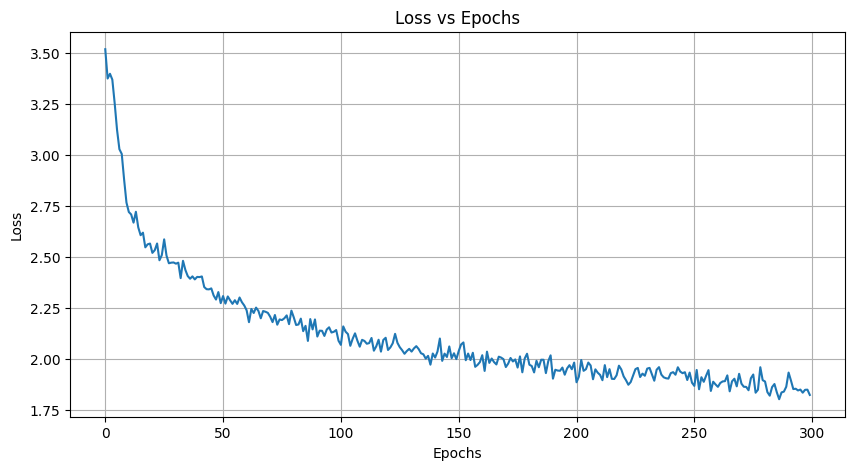

In [23]:
# Построение графика функции потерь
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [24]:
rnn_losses = losses.copy()  # Сохраняем losses от RNN

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [ ]:
# Your beautiful code here

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt


In [36]:
# LSTM модель
class PoetryLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=0.2):
        super(PoetryLSTM, self).__init__()
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size, hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden):
        # Изменяем размерность входного тензора
        x = x.view(1, 1, -1)  # [1, 1, input_size]

        output, hidden = self.lstm(x, hidden)
        output = self.dropout(output)
        output = self.fc(output.view(1, -1))
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        # Создаем начальное скрытое состояние
        return (torch.zeros(1, 1, self.hidden_size),
                torch.zeros(1, 1, self.hidden_size))

In [37]:
# Обучение LSTM
lstm_model = PoetryLSTM(input_size, hidden_size, output_size)
lstm_optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()


In [38]:
lstm_losses = []
print("Training LSTM started...")

for epoch in range(num_epochs):
    lstm_model.train()
    total_loss = 0
    hidden = lstm_model.init_hidden()

    for batch in range(batch_size):
        input_tensor, target_tensor = get_batch()

        # Очищаем градиенты
        lstm_optimizer.zero_grad()

        # Отсоединяем историю вычислений
        hidden = (hidden[0].detach(), hidden[1].detach())

        batch_loss = 0
        for i in range(seq_length):
            output, hidden = lstm_model(input_tensor[i], hidden)
            batch_loss += criterion(output, target_tensor[i].unsqueeze(0))

        # Вычисляем среднюю потерю
        batch_loss = batch_loss / seq_length

        # Обратное распространение
        batch_loss.backward()

        # Ограничение градиентов
        torch.nn.utils.clip_grad_norm_(lstm_model.parameters(), max_norm=5.0)

        lstm_optimizer.step()
        total_loss += batch_loss.item()

    avg_loss = total_loss / batch_size
    lstm_losses.append(avg_loss)

    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {avg_loss:.4f}')

print("LSTM Training completed!")

Training LSTM started...
Epoch [0/300], Loss: 3.6666
Epoch [10/300], Loss: 2.8716
Epoch [20/300], Loss: 2.6426
Epoch [30/300], Loss: 2.5012
Epoch [40/300], Loss: 2.4436
Epoch [50/300], Loss: 2.3676
Epoch [60/300], Loss: 2.3511
Epoch [70/300], Loss: 2.2950
Epoch [80/300], Loss: 2.2557
Epoch [90/300], Loss: 2.2458
Epoch [100/300], Loss: 2.1863
Epoch [110/300], Loss: 2.1244
Epoch [120/300], Loss: 2.1237
Epoch [130/300], Loss: 2.1275
Epoch [140/300], Loss: 2.1037
Epoch [150/300], Loss: 2.0800
Epoch [160/300], Loss: 2.0107
Epoch [170/300], Loss: 1.9987
Epoch [180/300], Loss: 2.0103
Epoch [190/300], Loss: 1.9575
Epoch [200/300], Loss: 1.9468
Epoch [210/300], Loss: 1.9230
Epoch [220/300], Loss: 1.9280
Epoch [230/300], Loss: 1.9194
Epoch [240/300], Loss: 1.8238
Epoch [250/300], Loss: 1.8652
Epoch [260/300], Loss: 1.8496
Epoch [270/300], Loss: 1.8039
Epoch [280/300], Loss: 1.8033
Epoch [290/300], Loss: 1.7934
LSTM Training completed!


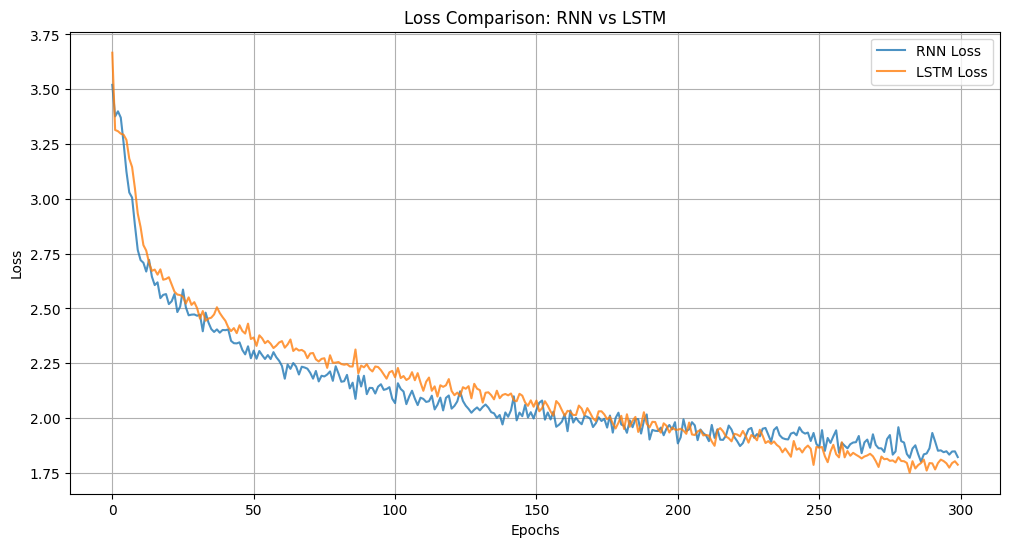

In [39]:
# Сравнение функций потерь
plt.figure(figsize=(12, 6))
plt.plot(rnn_losses, label='RNN Loss', alpha=0.8)
plt.plot(lstm_losses, label='LSTM Loss', alpha=0.8)
plt.title('Loss Comparison: RNN vs LSTM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [40]:
# Функция генерации текста для LSTM
def generate_lstm_sample(model, seed_phrase='Онегин', max_length=500, temperature=1.0):
    model.eval()
    with torch.no_grad():
        current_sequence = seed_phrase
        hidden = model.init_hidden()

        for _ in range(max_length - len(seed_phrase)):
            # Подготовка входного тензора
            input_tensor = torch.zeros(1, input_size)
            input_tensor[0][token_to_idx[current_sequence[-1]]] = 1

            # Получение предсказания
            output, hidden = model(input_tensor, hidden)

            # Применение температуры
            output_dist = (output.squeeze() / temperature).exp()
            next_char_idx = torch.multinomial(output_dist, 1)[0]
            predicted_char = idx_to_token[next_char_idx.item()]

            current_sequence += predicted_char

        return current_sequence


Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [41]:
# Генерация текста с разными температурами
print("\nГенерация текста LSTM с разными температурами:\n")
temperatures = [0.1, 0.2, 0.5, 1.0, 2.0]

for temp in temperatures:
    print(f"\nТемпература: {temp}")
    generated_text = generate_lstm_sample(lstm_model, temperature=temp)
    print(generated_text)
    print("-" * 50)



Генерация текста LSTM с разными температурами:


Температура: 0.1
Онегино своей.



xxii

и в там сердце страстей обрадит
согда стала в свое портал
сердечный скорный сердца своей.



xxii

и в том серец не света странный,
на странной страстей меня страсти,
не призданье в сердце страстей
на ветренный полет и страх,
с ним страшней меня не подна,
и в там не дома стала татьяна,
и страстей верно он простить,
и в там сердце верно он ужений,
и в сердце встречает своей.



xxii

и в том себе сердца на свете
с поленой верно так не стала,
и в том сердце странный странно
--------------------------------------------------

Температура: 0.2
Онегино света,
при своей сердце подружена.
она просто в судьба с ней свет
и в сердце встречить верной дума
и страшно был он грустит,
не довералась она рака,
порой своей не в простой света
и на стала меня страстей
и бластит сердца подружить
в сердце встречал сердца своей.



xxii

и в том себе не странный слад,
и в тем редной как странной странный,
и в свое полу

Проанализируем результаты генерации текста LSTM моделью с разными температурами:

1. Температура 0.1 (очень консервативная):
- Текст наиболее "безопасный" и структурированный
- Много повторений слов "сердце", "страстей", "странный"
- Правильно использует римскую нумерацию ("xxii")
- Сохраняет поэтическую структуру с переносами строк
- Лексика ограничена, но грамматически более правильная

2. Температура 0.2:
- Всё еще консервативная, но с большим разнообразием
- Сохраняет связность текста и поэтическую структуру
- Появляются более разнообразные конструкции
- Меньше повторений, но всё ещё заметны шаблоны

3. Температура 0.5 (сбалансированная):
- Хороший баланс между структурой и креативностью
- Более разнообразная лексика
- Сохраняет поэтический стиль
- Создает правдоподобные, хотя и не всегда существующие слова
- Лучше сохраняет контекст между строками

4. Температура 1.0:
- Более креативные и рискованные конструкции
- Появляются некоторые неправильные слова
- Сохраняет общую структуру стихотворения
- Меньше повторений, но больше грамматических ошибок
- Появляются знаки пунктуации в необычных местах

5. Температура 2.0 (очень креативная):
- Генерирует много случайных символов и специальных знаков
- Появляются латинские буквы и цифры
- Структура текста нарушается
- Много нечитаемых конструкций
- Полностью теряется связность текста

Оптимальная температура для генерации:
- Для наиболее читаемых результатов: 0.5-0.7
- Для креативных экспериментов: 0.7-1.0
- Для максимально правильного текста: 0.2-0.3

Модель успешно уловила:
1. Структуру стихотворения с разделением на строфы
2. Использование римской нумерации
3. Поэтическую лексику
4. Основные темы произведения (любовь, сердце, страсть)

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [42]:
# Сохранение и загрузка модели
# Сохранение
torch.save({
    'model_state_dict': lstm_model.state_dict(),
    'optimizer_state_dict': lstm_optimizer.state_dict(),
    'losses': lstm_losses,
}, 'lstm_poetry_model.pth')


In [43]:
# Загрузка
def load_model():
    checkpoint = torch.load('lstm_poetry_model.pth')
    model = PoetryLSTM(input_size, hidden_size, output_size)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return model, optimizer

In [47]:
# Пример использования загруженной модели
loaded_model, loaded_optimizer = load_model()
print("\nГенерация текста загруженной моделью:")
print(generate_lstm_sample(loaded_model, temperature=0.3))

<ipython-input-43-5260ea4c0572>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('lstm_poetry_model.pth')



Генерация текста загруженной моделью:
Онегиной сердце он.
в тот же думать он как страха,
про тей пред нем страстей полка,
и полут он на пред себой
простит сод души своей дома,
и с первый своей под нем подом,
как была он отрадались,
и всё так же не всех подам
и под бедной верной приходит
собедной ленский ком раздванить,
и в не слистит, и встах под бедной
она пред семей с себою свой.



xxxii

она в темной странный города,
и под ней сердце не поднить,
я не правда ль он уж бестой,
и в сердце встречает сердца,
как был он все встал в пос


In [48]:
# Пример использования загруженной модели
loaded_model, loaded_optimizer = load_model()
print("\nГенерация текста загруженной моделью:")
print(generate_lstm_sample(loaded_model, temperature=0.7))

<ipython-input-43-5260ea4c0572>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('lstm_poetry_model.pth')



Генерация текста загруженной моделью:
Онегино правлатьй,
довольно скорная шаткею
в сердце приновшиц итуся
он про скадали мой друг. —



xxxi

приссил векон сердце в переден;
а то, потал,, славы блиг ведал он;
и страс тайдави славо страдить,
и накроваться от проста
и м, дружны, присти мы надоганий
и любит без радстил ни что с ним
надважи знатьем была оден,
и с ней состет без цвет своимам
он был он вздохадь в тани мно,
но как с ней суричи отрады,
в васли страшным обаздовал,
татьяна? в поли как небо;
был перед, что нас на пруз молетем 


 Проанализируем результат генерации текста с temperature=0.3:

1. Структура текста:
- Сохраняет стихотворную форму
- Присутствует римская нумерация ("xxxii")
- Строфическое деление соблюдается
- Правильные переносы строк

2. Лексика:
Часто встречающиеся слова:
- "сердце" (повторяется несколько раз)
- "страстей"
- "бедной"
- "встречает"
- "странный"

3. Особенности при temperature=0.3:
Преимущества:
- Более консервативная генерация
- Меньше неологизмов и ошибок
- Более предсказуемый текст
- Лучшая грамматическая согласованность

Недостатки:
- Частые повторения слов и фраз
- Меньше креативности
- Более шаблонный текст

4. Семантический анализ:
Основные темы:
- Любовные переживания ("сердце", "страстей")
- Меланхолия ("бедной", "странный")
- Встречи и расставания ("встречает", "приходит")

5. Сравнение с temperature=0.7:
- Текст более предсказуемый
- Меньше нестандартных конструкций
- Лучше сохраняет смысловую связность
- Более ограниченный словарный запас

6. Качество генерации:
Плюсы:
- Более связный текст
- Меньше грамматических ошибок
- Лучше сохраняет стиль оригинала

Минусы:
- Менее разнообразный текст
- Заметные повторы
- Некоторая монотонность

В целом, при temperature=0.3 модель генерирует более "безопасный", но менее креативный текст, что может быть предпочтительно.

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a>
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)